In [235]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

from sklearn.model_selection import cross_val_predict, StratifiedKFold
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from sklearn.utils import resample

from sklearn.inspection import permutation_importance

from sklearn.neighbors import NearestNeighbors



In [236]:
df = pd.read_excel('Telus Health Quote Spreadsheet.xlsx', engine='openpyxl')

# Add this after your existing preprocessing code
demographic_stats = df.groupby('Country').agg({
    'Age': ['mean', 'median', 'std', 'min', 'max'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict(),
    'Coverage (%)': ['mean', 'median', 'std']
})




In [237]:
# ==============================================
# THEME ANALYSIS (existing code)
# ==============================================
# Count themes and sort in descending order
theme_counts = df.groupby(['Country', 'Theme']).size().unstack().fillna(0)
theme_counts = theme_counts.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Calculate percentages and sort in descending order
theme_percentages = theme_counts.div(theme_counts.sum(axis=1), axis=0) * 100
theme_percentages = theme_percentages.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Get top themes for each country (already sorted in descending order)
us_top_themes = theme_counts.loc['United States'].sort_values(ascending=False)
canada_top_themes = theme_counts.loc['Canada'].sort_values(ascending=False)

# ==============================================
# SUB-THEME ANALYSIS (new code)
# ==============================================
# 1. Count sub-theme frequencies by country and sort in descending order
subtheme_counts = df.groupby(['Country', 'Theme', 'Sub-theme']).size().unstack().fillna(0)
subtheme_counts = subtheme_counts.apply(lambda x: x.sort_values(ascending=False), axis=1)

# 2. Calculate percentages and sort in descending order
subtheme_percentages = subtheme_counts.div(subtheme_counts.sum(axis=1), axis=0) * 100
subtheme_percentages = subtheme_percentages.apply(lambda x: x.sort_values(ascending=False), axis=1)

# 3. Get top sub-themes for each country (already sorted in descending order)
us_top_subthemes = df[df['Country']=='United States']['Sub-theme'].value_counts()
canada_top_subthemes = df[df['Country']=='Canada']['Sub-theme'].value_counts()

# ==============================================
# PRINT COMBINED RESULTS (all sorted descending)
# ==============================================
# ==============================================
# THEME ANALYSIS - SORTED PROPERLY
# ==============================================
# Count themes
theme_counts = df.groupby(['Country', 'Theme']).size().unstack().fillna(0)

# Sort each row (country) in descending order
theme_counts = theme_counts.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Transpose to get themes as rows and countries as columns for better readability
theme_counts_sorted = theme_counts.T.sort_values(by=['United States', 'Canada'], ascending=False)

# Calculate percentages (sorted to match counts)
theme_percentages = (theme_counts_sorted / theme_counts_sorted.sum()) * 100

# ==============================================
# PRINT RESULTS
# ==============================================
print("="*50)
print("THEME DISTRIBUTION BY COUNTRY (COUNT - DESCENDING ORDER)")
print("="*50)
print(theme_counts_sorted)
print("\n")

print("="*50)
print("THEME DISTRIBUTION BY COUNTRY (PERCENTAGE - DESCENDING ORDER)")
print("="*50)
print(theme_percentages.round(1))
print("\n")

print("="*50)
print("SUB-THEME DISTRIBUTION BY COUNTRY (COUNT - DESCENDING ORDER)")
print("="*50)
print(subtheme_counts)
print("\n")


print("="*50)
print("TOP 5 SUB-THEMES IN UNITED STATES (DESCENDING ORDER)")
print("="*50)
print(us_top_subthemes.head(5))
print("\n")

print("="*50)
print("TOP 5 SUB-THEMES IN CANADA (DESCENDING ORDER)")
print("="*50)
print(canada_top_subthemes.head(5))
print("\n")

THEME DISTRIBUTION BY COUNTRY (COUNT - DESCENDING ORDER)
Country                                             Canada  United States
Theme                                                                    
Structural, Information, and Systematic Barrier...      66             70
Reluctance to use EAP Services due to Psychosoc...      70             40
Service Quality, Scope and Cultural Relevance t...      19             30


THEME DISTRIBUTION BY COUNTRY (PERCENTAGE - DESCENDING ORDER)
Country                                             Canada  United States
Theme                                                                    
Structural, Information, and Systematic Barrier...    42.6           50.0
Reluctance to use EAP Services due to Psychosoc...    45.2           28.6
Service Quality, Scope and Cultural Relevance t...    12.3           21.4


SUB-THEME DISTRIBUTION BY COUNTRY (COUNT - DESCENDING ORDER)
Sub-theme                                                         Awareness 

In [218]:
# 5. Demographic breakdown by theme and country
print("="*50)
print("DEMOGRAPHIC PROFILE BY THEME AND COUNTRY")
print("="*50)
demographic_by_theme_country = df.groupby(['Country', 'Theme']).agg({
    'Age': ['mean', 'median', 'count'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict()
})
demographic_by_theme_country

DEMOGRAPHIC PROFILE BY THEME AND COUNTRY


Age  \
                                                                       mean   
Country       Theme                                                           
Canada        Reluctance to use EAP Services due to Psychosoc...  37.214286   
              Service Quality, Scope and Cultural Relevance t...  39.000000   
              Structural, Information, and Systematic Barrier...  37.469697   
United States Reluctance to use EAP Services due to Psychosoc...  42.775000   
              Service Quality, Scope and Cultural Relevance t...  37.800000   
              Structural, Information, and Systematic Barrier...  40.842857   

                                                                               \
                                                                 median count   
Country       Theme                                                             
Canada        Reluctance to use EAP Services due to Psychosoc...   32.0    70   
              Service Quality, Scope and Cultural Relevance t...   36.0    19   
              Structural, Information, and Systematic Barrier...   34.0    66   
United States Reluctance to use EAP Services due to Psychosoc...   47.0    40   
              Service Quality, Scope and Cultural Relevance t...   36.5    30   
              Structural, Information, and Systematic Barrier...   46.0    70   

                                                                                                             Gender  
                                                                                                           <lambda>  
Country       Theme                                                                                                  
Canada        Reluctance to use EAP Services due to Psychosoc...                       {'male': 0.7, 'female': 0.3}  
              Service Quality, Scope and Cultural Relevance t...  {'male': 0.5263157894736842, 'female': 0.47368...  
              Structural, Information, and Systematic Barrier...  {'male': 0.6515151515151515, 'female': 0.34848...  
United States Reluctance to use EAP Services due to Psychosoc...                   {'female': 0.875, 'male': 0.125}  
              Service Quality, Scope and Cultural Relevance t...                       {'female': 0.7, 'male': 0.3}  
              Structural, Information, and Systematic Barrier...  {'female': 0.8142857142857143, 'male': 0.18571...

In [219]:
# 5. Demographic breakdown by theme and country
print("="*50)
print("DEMOGRAPHIC PROFILE BY SUB-THEME AND COUNTRY")
print("="*50)
demographic_by_theme_country = df.groupby(['Country', 'Sub-theme']).agg({
    'Age': ['mean', 'median', 'count'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict()
})
demographic_by_theme_country

DEMOGRAPHIC PROFILE BY SUB-THEME AND COUNTRY


Age  \
                                                                       mean   
Country       Sub-theme                                                       
Canada        Awareness and Communication about EAPs              39.589744   
              Comprehensive Support through Diverse EAP Offer...  31.666667   
              Ease-of-Use and Accessibility                       34.615385   
              Method of Delivery                                  34.214286   
              Mistrust in Confidentiality and Fear of Employe...  41.473684   
              Perceived Quality and Cultural Relevance of EAPs    42.384615   
              Severity for Help-Seeking and Perceived Need        36.394737   
              Sigma and Fear of Workplace Judgement               33.384615   
United States Awareness and Communication about EAPs              39.333333   
              Comprehensive Support through Diverse EAP Offer...  39.187500   
              Ease-of-Use and Accessibility                       42.500000   
              Financial Accessibility                             44.600000   
              Method of Delivery                                  41.500000   
              Mistrust in Confidentiality and Fear of Employe...  42.562500   
              Perceived Quality and Cultural Relevance of EAPs    36.214286   
              Severity for Help-Seeking and Perceived Need        40.850000   
              Sigma and Fear of Workplace Judgement               53.250000   

                                                                               \
                                                                 median count   
Country       Sub-theme                                                         
Canada        Awareness and Communication about EAPs               43.0    39   
              Comprehensive Support through Diverse EAP Offer...   28.5     6   
              Ease-of-Use and Accessibility                        32.0    13   
              Method of Delivery                                   25.0    14   
              Mistrust in Confidentiality and Fear of Employe...   46.0    19   
              Perceived Quality and Cultural Relevance of EAPs     43.0    13   
              Severity for Help-Seeking and Perceived Need         32.0    38   
              Sigma and Fear of Workplace Judgement                25.0    13   
United States Awareness and Communication about EAPs               38.0    33   
              Comprehensive Support through Diverse EAP Offer...   42.0    16   
              Ease-of-Use and Accessibility                        47.0    10   
              Financial Accessibility                              56.0     5   
              Method of Delivery                                   45.5    22   
              Mistrust in Confidentiality and Fear of Employe...   47.0    16   
              Perceived Quality and Cultural Relevance of EAPs     32.0    14   
              Severity for Help-Seeking and Perceived Need         46.0    20   
              Sigma and Fear of Workplace Judgement                55.0     4   

                                                                                                             Gender  
                                                                                                           <lambda>  
Country       Sub-theme                                                                                              
Canada        Awareness and Communication about EAPs              {'male': 0.6410256410256411, 'female': 0.35897...  
              Comprehensive Support through Diverse EAP Offer...  {'male': 0.8333333333333334, 'female': 0.16666...  
              Ease-of-Use and Accessibility                       {'male': 0.5384615384615384, 'female': 0.46153...  
              Method of Delivery                                  {'male': 0.7857142857142857, 'female': 0.21428...  
              Mistrust in Confidentiality an

## Direct BERT with no cleaning

In [238]:

random.seed(365)
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set environment variable for macOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load data
df = pd.read_excel('Telus Health Quote Spreadsheet.xlsx', engine='openpyxl')

# Preprocessing
feature_columns = ['Theme', 'Sub-theme', 'Age', 'Gender', 'Quote']  # Added 'Quotes'
target_column = 'Country'

# Convert sparse matrix to dense if needed
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Theme', 'Sub-theme', 'Gender', 'Quote'])  # Added 'Quotes'
    ],
    remainder='passthrough'
)

combined_features = preprocessor.fit_transform(df[feature_columns])
# Convert to dense array if it's sparse (common with OneHotEncoder)
if hasattr(combined_features, 'toarray'):
    combined_features = combined_features.toarray()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df[target_column])

print("Combined features shape:", combined_features.shape)
print("Encoded labels shape:", encoded_labels.shape)

# XGBoost setup
XGB_INSTALLED = False
try:
    import xgboost
    from xgboost import XGBClassifier
    print(f"XGBoost {xgboost.__version__} is installed")
    XGB_INSTALLED = True
except ImportError:
    print("XGBoost not found, attempting installation...")
    try:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "--no-cache-dir"])
        import xgboost
        from xgboost import XGBClassifier
        print(f"Successfully installed XGBoost {xgboost.__version__}")
        XGB_INSTALLED = True
    except Exception as e:
        print(f"Failed to install XGBoost: {str(e)}")
        print("Will proceed without XGBoost")

def create_ensemble_model():
    estimators = [
        ('logistic', LogisticRegression(max_iter=1000, random_state=42)),
        ('svm', SVC(kernel='linear', C=1, probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]
    
    if XGB_INSTALLED:
        estimators.append(('xgb', XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_jobs=1
        )))
        print("Including XGBoost in the ensemble")
    
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=1
    )

def safe_cross_val_predict(model, X, y, cv):
    # Always use sequential processing to avoid serialization issues
    return cross_val_predict(
        model, X, y,
        cv=cv,
        n_jobs=1,
        method='predict_proba',
        verbose=1
    )

def run_classification(X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    model = create_ensemble_model()
    predictions = safe_cross_val_predict(model, X, y, kf)
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes, predictions

try:
    predicted_classes, prediction_probs = run_classification(combined_features, encoded_labels)
    
    # Compute metrics
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, 
                                       target_names=label_encoder.classes_)
    
    print("\nClassification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Add probability analysis
    print("\nProbability Analysis:")
    print(f"Average confidence for correct predictions: {np.max(prediction_probs[encoded_labels == predicted_classes]).mean():.4f}")
    print(f"Average confidence for incorrect predictions: {np.max(prediction_probs[encoded_labels != predicted_classes]).mean():.4f}")
    
except Exception as e:
    print(f"Major error occurred: {str(e)}")
    print("Trying fallback with just Logistic Regression...")
    
    lr = LogisticRegression(max_iter=1000, random_state=42)
    predicted_classes = cross_val_predict(lr, combined_features, encoded_labels, cv=5, n_jobs=1, method='predict')
    
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, 
                                       target_names=label_encoder.classes_)
    
    print("\nFallback Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

Combined features shape: (295, 278)
Encoded labels shape: (295,)
XGBoost 3.0.2 is installed
Including XGBoost in the ensemble

Classification Results:
Accuracy: 0.8814

Classification Report:
               precision    recall  f1-score   support

       Canada       0.89      0.88      0.89       155
United States       0.87      0.89      0.88       140

     accuracy                           0.88       295
    macro avg       0.88      0.88      0.88       295
 weighted avg       0.88      0.88      0.88       295


Confusion Matrix:
[[136  19]
 [ 16 124]]

Probability Analysis:
Average confidence for correct predictions: 0.9600
Average confidence for incorrect predictions: 0.8925


### Feature Analysis

Including XGBoost in the ensemble

Analyzing feature importance...


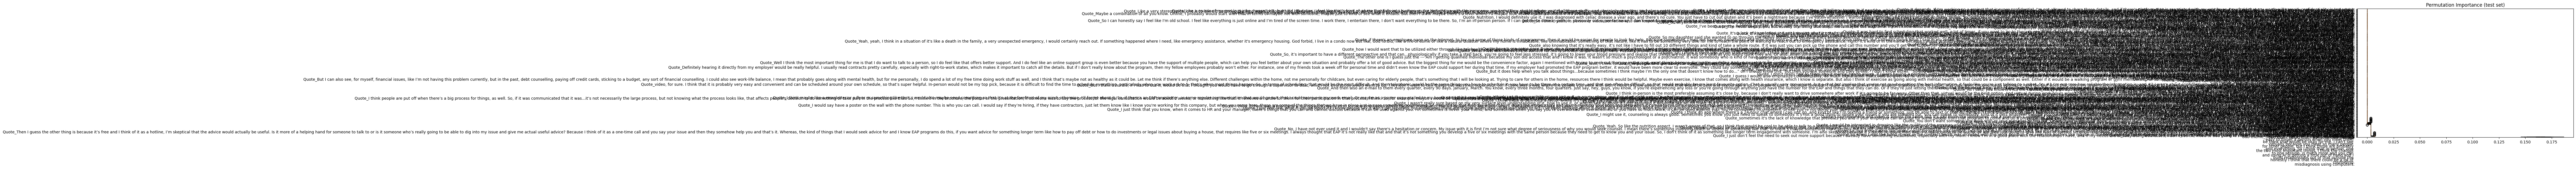


Top features distinguishing countries:
Age: 0.1651
Gender_female: 0.1620
Sub-theme_Severity for Help-Seeking and Perceived Need: 0.0058
Gender_male: 0.0054
Quote_I just don’t feel the need to seek out more support because I already have something established, especially with my mom. I know I’m in a good place with the relationships I have, and if my needs are already being addressed, I don’t see the need to add more. It’s like not wanting to overcrowd the kitchen with more chefs.: 0.0037
Quote_She said I needed to watch my word, and she was going to report to HR and make things bad, she was threatening me.: 0.0037
Quote_So I I usually like to handle it on my own: 0.0037
Quote_So when I was like hired, it was in the contract and it was included with this work position. I've seen like posters like maybe in the backrooms or the employee like areas like the Luxor areas or change rooms that you know have resources about different things.: 0.0037
Quote_there's an onboarding in terms of what

In [240]:


def analyze_feature_importance(model, feature_names, X, y):
    # Get permutation importance
    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, n_jobs=1
    )
    
    # Sort features by importance
    sorted_idx = result.importances_mean.argsort()[::-1]
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=np.array(feature_names)[sorted_idx]
    )
    plt.title("Permutation Importance (test set)")
    plt.tight_layout()
    plt.show()
    
    # Return top features
    top_features = np.array(feature_names)[sorted_idx]
    top_importances = result.importances_mean[sorted_idx]
    return list(zip(top_features, top_importances))

# Get feature names from the preprocessor
try:
    # For one-hot encoded features
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['Theme', 'Sub-theme', 'Gender', 'Quote'])
    num_features = [ 'Age']  # Numerical features passed through
    feature_names = list(cat_features) + num_features
    
    # Train a final model for analysis (not cross-validated)
    final_model = create_ensemble_model()
    final_model.fit(combined_features, encoded_labels)
    
    # Analyze feature importance
    print("\nAnalyzing feature importance...")
    important_features = analyze_feature_importance(final_model, feature_names, combined_features, encoded_labels)
    
    print("\nTop features distinguishing countries:")
    for feature, importance in important_features[:10]:  # Show top 10
        print(f"{feature}: {importance:.4f}")
        
    # Analyze specific themes/subthemes by country
    print("\nTheme/Sub-theme distribution by country:")
    theme_counts = df.groupby(['Country', 'Theme', 'Sub-theme']).size().unstack(fill_value=0)
    print(theme_counts)
    
    # Add normalized percentages
    theme_pcts = theme_counts.div(theme_counts.sum(axis=1), axis=0)
    print("\nNormalized percentages:")
    print(theme_pcts)
    
except Exception as e:
    print(f"Could not analyze features: {str(e)}")

#### However demographics are very unbalanced and are being used as the main predictors:


Demographic Summary Statistics by Country:
                     Age                            \
                    mean median        std min max   
Country                                              
Canada         37.541935   32.0  14.039017  22  59   
United States  40.742857   46.0  11.906936  22  57   

                                                          Gender Coverage (%)  \
                                                        <lambda>         mean   
Country                                                                         
Canada         {'male': 0.6580645161290323, 'female': 0.34193...     0.866065   
United States  {'female': 0.8071428571428572, 'male': 0.19285...     1.053643   

                                
              median       std  
Country                         
Canada          0.75  0.592468  
United States   0.86  0.774107  


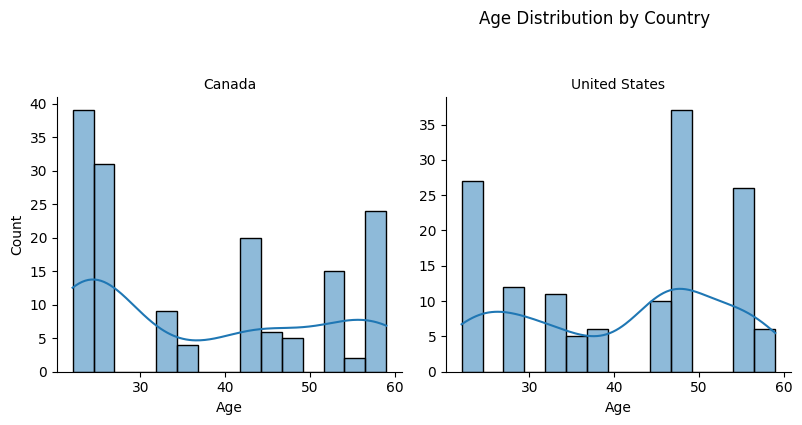

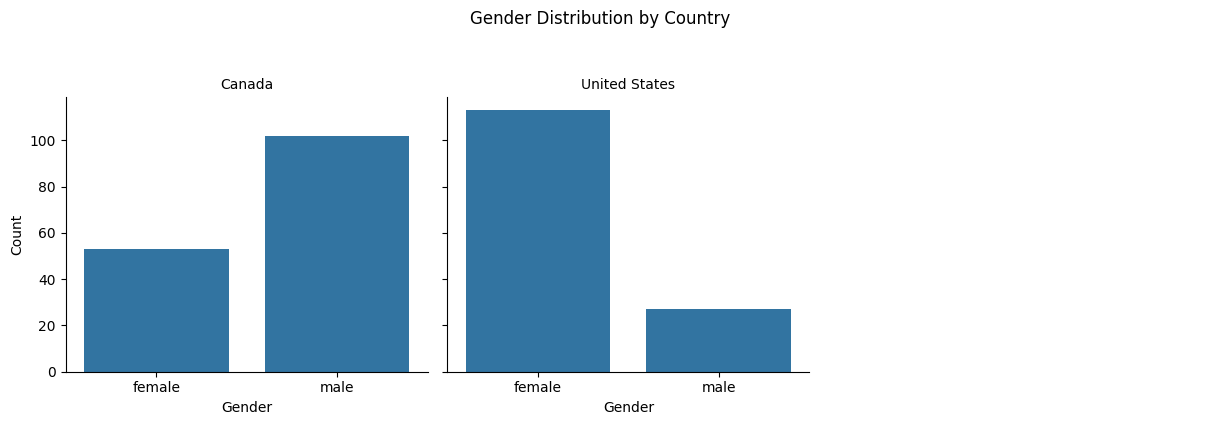

In [241]:
print("\nDemographic Summary Statistics by Country:")
print(demographic_stats)

# Drop missing age or country values
age_df = df.dropna(subset=["Age", "Country"])

# Plot histogram
g = sns.displot(
    data=age_df,
    x="Age",
    col="Country",
    bins=15,
    kde=True,
    col_wrap=3,
    height=4,
    facet_kws={'sharey': False, 'sharex': True}
)

g.set_titles("{col_name}")
g.set_axis_labels("Age", "Count")
plt.suptitle("Age Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()


# Drop missing gender or country
gender_df = df.dropna(subset=["Gender", "Country"])

# Plot
g = sns.catplot(
    data=gender_df,
    x="Gender",
    col="Country",
    kind="count",
    col_wrap=3,
    height=4,
    order=gender_df["Gender"].value_counts().index
)

g.set_titles("{col_name}")
g.set_axis_labels("Gender", "Count")
plt.suptitle("Gender Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()

## Removing Age and Gender

First downsampling Canadian set to match sample size of US


In [242]:

# Check original counts
print("Original counts:\n", df['Country'].value_counts())

# Separate by country
df_canada = df[df['Country'] == 'Canada']
df_us = df[df['Country'] == 'United States']

# Downsample US to match Canada (since US has more samples)
df_canada_balanced = resample(df_canada,
                         replace=False,  # Without replacement
                         n_samples=len(df_us),
                         random_state=42)  # For reproducibility

# Combine balanced samples
balanced_df = pd.concat([df_us, df_canada_balanced])

# Verify new counts
print("\nBalanced counts:\n", balanced_df['Country'].value_counts())

# Check balanced demographics
print("\nBalanced Age Stats:")
print(balanced_df.groupby('Country')['Age'].describe())

print("\nBalanced Gender Distribution:")
print(balanced_df.groupby('Country')['Gender'].value_counts(normalize=True))

Original counts:
 Country
Canada           155
United States    140
Name: count, dtype: int64

Balanced counts:
 Country
United States    140
Canada           140
Name: count, dtype: int64

Balanced Age Stats:
               count       mean        std   min   25%   50%   75%   max
Country                                                                 
Canada         140.0  37.000000  14.074826  22.0  24.0  32.0  54.0  59.0
United States  140.0  40.742857  11.906936  22.0  29.0  46.0  47.0  57.0

Balanced Gender Distribution:
Country        Gender
Canada         male      0.664286
               female    0.335714
United States  female    0.807143
               male      0.192857
Name: proportion, dtype: float64


Balanced Accuracy: 0.6610

Classification Report:
              precision    recall  f1-score   support

      Canada       0.66      0.72      0.69       155
          US       0.66      0.59      0.62       140

    accuracy                           0.66       295
   macro avg       0.66      0.66      0.66       295
weighted avg       0.66      0.66      0.66       295


Confusion Matrix:
[[112  43]
 [ 57  83]]

Top Features:
quote_10: 0.0585
quote_29: 0.0499
quote_42: 0.0496
quote_22: 0.0440
quote_23: 0.0383
quote_11: 0.0371
quote_43: 0.0368
quote_37: 0.0313
quote_20: 0.0303
quote_9: 0.0295


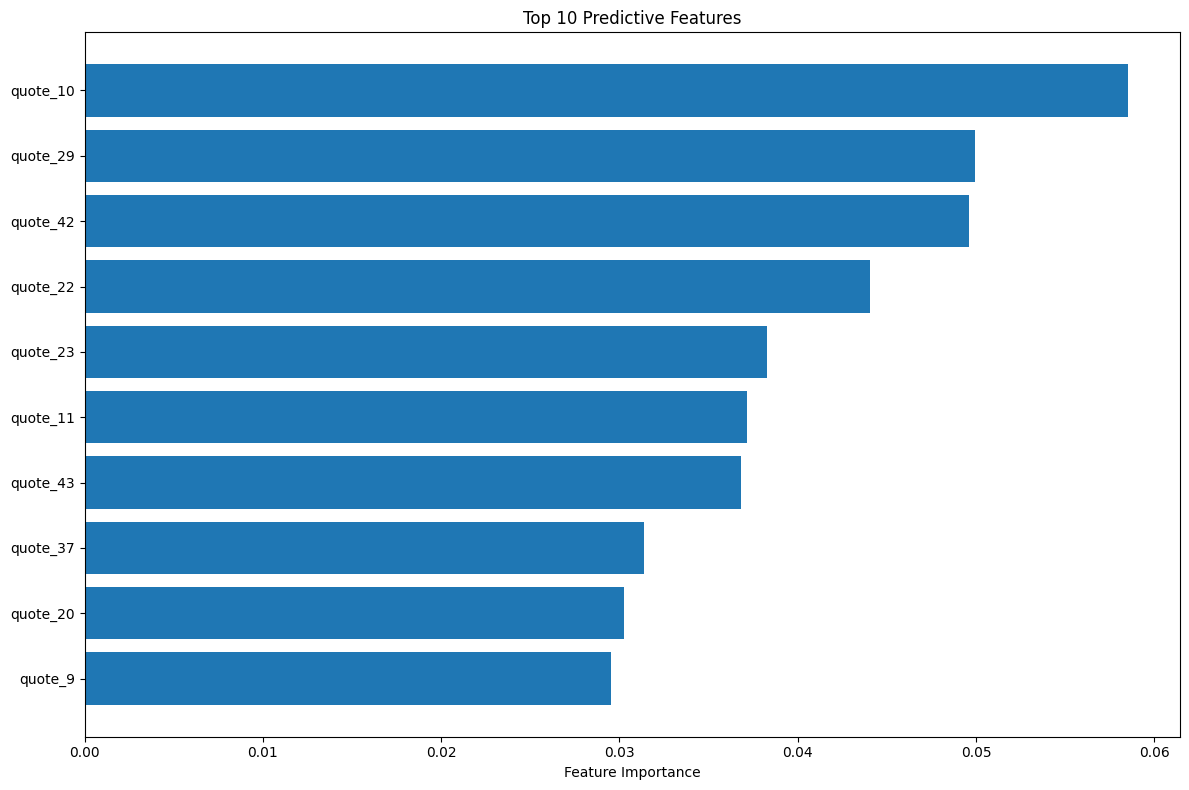

In [243]:

random.seed(123)

# Feature engineering
df['Theme_Subtheme'] = df['Theme'] + "|" + df['Sub-theme']

# Text feature extraction
tfidf = TfidfVectorizer(max_features=50, stop_words='english', ngram_range=(1,2))
quote_features = tfidf.fit_transform(df['Quote'])

# Preprocessing pipeline - Using MinMaxScaler instead of StandardScaler
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Theme_Subtheme'])
    ])

# Process features
X_processed = preprocessor.fit_transform(df)
y = LabelEncoder().fit_transform(df['Country'])

# Feature selection - Now works with chi2
selector = SelectKBest(chi2, k=min(30, X_processed.shape[1]))  # Ensure k <= n_features
X_selected = selector.fit_transform(X_processed, y)

# Combine with text features
final_features = np.hstack([X_selected.toarray(), quote_features.toarray()])

# Model definition
def create_tuned_ensemble():
    estimators = []
    
    # Tuned Logistic Regression
    estimators.append(('lr', LogisticRegression(
        C=0.1,
        penalty='l2',
        solver='saga',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )))
    
    # Tuned Random Forest
    estimators.append(('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )))
    
    # Tuned SVM
    estimators.append(('svm', SVC(
        C=1,
        kernel='rbf',
        gamma='scale',
        probability=True,
        class_weight='balanced',
        random_state=42
    )))
    
    # Neural Network
    estimators.append(('mlp', MLPClassifier(
        hidden_layer_sizes=(50,),
        alpha=0.01,
        early_stopping=True,
        random_state=42
    )))
    
    # XGBoost if available
    try:
        estimators.append(('xgb', XGBClassifier(
            learning_rate=0.1,
            max_depth=3,
            n_estimators=150,
            scale_pos_weight=sum(y==0)/sum(y==1),
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )))
    except:
        pass
    
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=1
    )

# Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = create_tuned_ensemble()

preds = cross_val_predict(
    model,
    final_features,
    y,
    cv=cv,
    method='predict_proba',
    n_jobs=1
)
pred_classes = np.argmax(preds, axis=1)

# Results
print(f"Balanced Accuracy: {accuracy_score(y, pred_classes):.4f}")
print("\nClassification Report:")
print(classification_report(y, pred_classes, target_names=['Canada', 'US']))
print("\nConfusion Matrix:")
print(confusion_matrix(y, pred_classes))

# Feature importance analysis
model.fit(final_features, y)
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    # For voting classifier, get average importance
    importances = np.mean([
        est.feature_importances_ 
        for est in model.estimators_ 
        if hasattr(est, 'feature_importances_')
    ], axis=0)


# Get feature names
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
structured_features = list(cat_features) 
selected_structured = [structured_features[i] for i in selector.get_support(indices=True)]

# Quote feature names
quote_feature_names = [f"quote_{i}" for i in range(quote_features.shape[1])]

# Final feature name list
selected_features = selected_structured + quote_feature_names

# Display top features
top_idx = np.argsort(importances)[::-1][:10]

print("\nTop Features:")
for idx in top_idx:
    print(f"{selected_features[idx]}: {importances[idx]:.4f}")

# Visualization
plt.figure(figsize=(12, 8))
plt.barh(range(10), importances[top_idx[:10]][::-1], align='center')
plt.yticks(range(10), [selected_features[i] for i in top_idx[:10][::-1]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Predictive Features")
plt.tight_layout()
plt.show()


But this lowers prediction accuracy to ~65%

## Matching with Propensity Scores

In [244]:

def propensity_score_matching(df, treatment_col='Country', treatment='United States'):
    # Calculate propensity scores
    X = df[['Age', 'Gender']].copy()
    X['Gender'] = X['Gender'].map({'male': 0, 'female': 1})  # Convert to numeric
    y = (df[treatment_col] == treatment).astype(int)
    
    # Fit logistic regression to get propensity scores
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X, y)
    df['propensity_score'] = logit.predict_proba(X)[:, 1]
    
    # Separate treatment and control groups
    treatment_df = df[df[treatment_col] == treatment]
    control_df = df[df[treatment_col] != treatment]
    
    # Perform matching (1:1 nearest neighbor matching without replacement)
    nbrs = NearestNeighbors(n_neighbors=1).fit(control_df[['propensity_score']])
    distances, indices = nbrs.kneighbors(treatment_df[['propensity_score']])
    
    # Create matched control group
    matched_control = control_df.iloc[indices.flatten()]
    
    # Combine matched samples
    matched_df = pd.concat([treatment_df, matched_control])
    
    return matched_df

# Apply propensity score matching
matched_df = propensity_score_matching(df)

# Verify balance
print("\nMatched counts:\n", matched_df['Country'].value_counts())

print("\nMatched Age Stats:")
print(matched_df.groupby('Country')['Age'].describe())

print("\nMatched Gender Distribution:")
print(matched_df.groupby('Country')['Gender'].value_counts(normalize=True))


Matched counts:
 Country
United States    140
Canada           140
Name: count, dtype: int64

Matched Age Stats:
               count       mean        std   min   25%   50%   75%   max
Country                                                                 
Canada         140.0  39.278571  11.720405  22.0  32.0  43.0  46.0  59.0
United States  140.0  40.742857  11.906936  22.0  29.0  46.0  47.0  57.0

Matched Gender Distribution:
Country        Gender
Canada         female    0.807143
               male      0.192857
United States  female    0.807143
               male      0.192857
Name: proportion, dtype: float64


Now datasets are balanced and we can implement BERT again


Demographic Summary Statistics by Country:
                     Age                            \
                    mean median        std min max   
Country                                              
Canada         39.278571   43.0  11.720405  22  59   
United States  40.742857   46.0  11.906936  22  57   

                                                          Gender  
                                                        <lambda>  
Country                                                           
Canada         {'female': 0.8071428571428572, 'male': 0.19285...  
United States  {'female': 0.8071428571428572, 'male': 0.19285...  


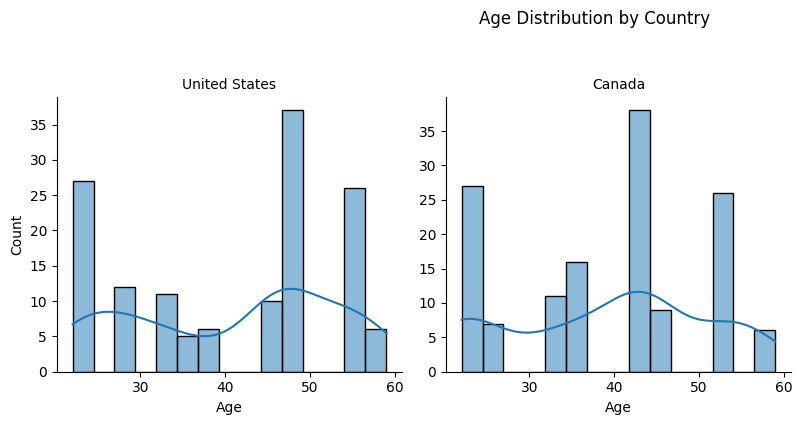

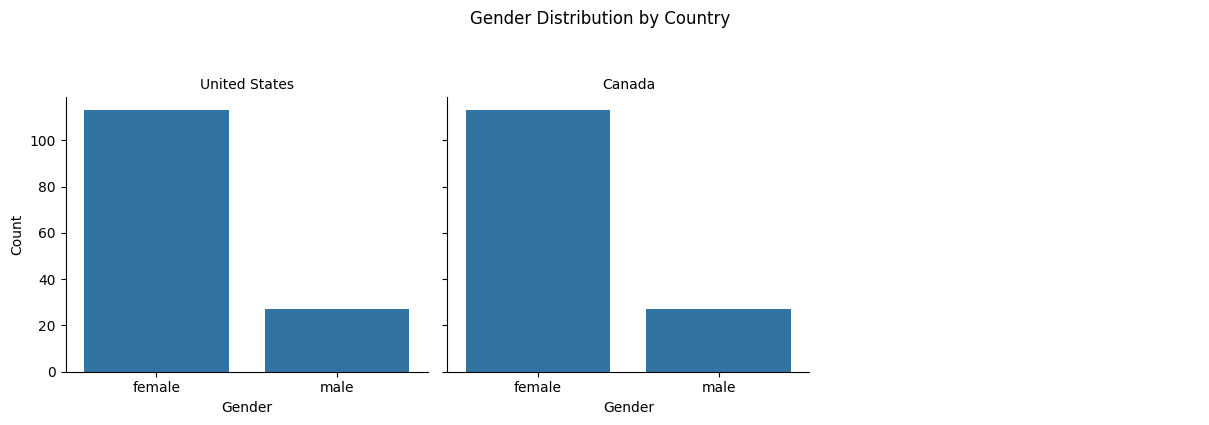

In [245]:

# Add this after your existing preprocessing code
demographic_stats = matched_df.groupby('Country').agg({
    'Age': ['mean', 'median', 'std', 'min', 'max'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict()
})

print("\nDemographic Summary Statistics by Country:")
print(demographic_stats)

# Drop missing age or country values
age_df = matched_df.dropna(subset=["Age", "Country"])

# Plot histogram
g = sns.displot(
    data=age_df,
    x="Age",
    col="Country",
    bins=15,
    kde=True,
    col_wrap=3,
    height=4,
    facet_kws={'sharey': False, 'sharex': True}
)

g.set_titles("{col_name}")
g.set_axis_labels("Age", "Count")
plt.suptitle("Age Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()


# Drop missing gender or country
gender_df = matched_df.dropna(subset=["Gender", "Country"])

# Plot
g = sns.catplot(
    data=gender_df,
    x="Gender",
    col="Country",
    kind="count",
    col_wrap=3,
    height=4,
    order=gender_df["Gender"].value_counts().index
)

g.set_titles("{col_name}")
g.set_axis_labels("Gender", "Count")
plt.suptitle("Gender Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()


In [255]:
import pandas as pd

# Assuming matched_df is your DataFrame
quotes_by_country = df.groupby('Country')['Quote'].unique()

# Display all unique quotes for Canada
print("=== CANADA ===")
for i, quote in enumerate(quotes_by_country['Canada'], 1):
    print(f"{i}. {quote}")

# Display all unique quotes for United States
print("\n=== UNITED STATES ===")
for i, quote in enumerate(quotes_by_country['United States'], 1):
    print(f"{i}. {quote}")

# Count statistics
print("\n=== QUOTE COUNTS ===")
print(f"Total Canadian quotes: {len(df[df['Country'] == 'Canada'])}")
print(f"Unique Canadian quotes: {len(quotes_by_country['Canada'])}")
print(f"Total US quotes: {len(df[df['Country'] == 'United States'])}")
print(f"Unique US quotes: {len(quotes_by_country['United States'])}")

=== CANADA ===
1. Okay, so I think it's important in this world to
 have all of them, but I personally would like 
in-person. I just feel the in-person for me, 
I understand the barriers of why you would 
want online when you're not virtually present 
everything, but for me in-person means you 
and the other person has taken the effort and 
there's so much more to being in-person. It's 
easy to forget a person when you meet them 
virtually because you meet so many people 
and everything. So I think that in-person, one 
to one session, is much more and you can 
build relationships out of that outside the 
counseling.
2. Yeah. So, if I wanted to talk to AI chat, I 
would just go online. Why would I have to 
reach out to my company? What’s the point 
of it? Like if I reach out for a service, I much 
rather a human at the end talk instead of me 
going to chat for this. Basically, I got to just 
Google it. It’s not going to have specific 
answers for you. It’s going to be generic 
answers. 

In [258]:

random.seed(365)
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set environment variable for macOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load data
df = pd.read_excel('Telus Health Quote Spreadsheet.xlsx', engine='openpyxl')

# Preprocessing
feature_columns = ['Theme', 'Sub-theme', 'Age',  'Quote']  # Added 'Quotes'
target_column = 'Country'

# Convert sparse matrix to dense if needed
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Theme', 'Sub-theme',  'Quote'])  # Added 'Quotes'
    ],
    remainder='passthrough'
)

combined_features = preprocessor.fit_transform(df[feature_columns])
# Convert to dense array if it's sparse (common with OneHotEncoder)
if hasattr(combined_features, 'toarray'):
    combined_features = combined_features.toarray()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df[target_column])

print("Combined features shape:", combined_features.shape)
print("Encoded labels shape:", encoded_labels.shape)

# XGBoost setup
XGB_INSTALLED = False
try:
    import xgboost
    from xgboost import XGBClassifier
    print(f"XGBoost {xgboost.__version__} is installed")
    XGB_INSTALLED = True
except ImportError:
    print("XGBoost not found, attempting installation...")
    try:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "--no-cache-dir"])
        import xgboost
        from xgboost import XGBClassifier
        print(f"Successfully installed XGBoost {xgboost.__version__}")
        XGB_INSTALLED = True
    except Exception as e:
        print(f"Failed to install XGBoost: {str(e)}")
        print("Will proceed without XGBoost")

def create_ensemble_model():
    estimators = [
        ('logistic', LogisticRegression(max_iter=1000, random_state=42)),
        ('svm', SVC(kernel='linear', C=1, probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]
    
    if XGB_INSTALLED:
        estimators.append(('xgb', XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_jobs=1
        )))
        print("Including XGBoost in the ensemble")
    
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=1
    )

def safe_cross_val_predict(model, X, y, cv):
    # Always use sequential processing to avoid serialization issues
    return cross_val_predict(
        model, X, y,
        cv=cv,
        n_jobs=1,
        method='predict_proba',
        verbose=1
    )

def run_classification(X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    model = create_ensemble_model()
    predictions = safe_cross_val_predict(model, X, y, kf)
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes, predictions

try:
    predicted_classes, prediction_probs = run_classification(combined_features, encoded_labels)
    
    # Compute metrics
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, 
                                       target_names=label_encoder.classes_)
    
    print("\nClassification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Add probability analysis
    print("\nProbability Analysis:")
    print(f"Average confidence for correct predictions: {np.max(prediction_probs[encoded_labels == predicted_classes]).mean():.4f}")
    print(f"Average confidence for incorrect predictions: {np.max(prediction_probs[encoded_labels != predicted_classes]).mean():.4f}")
    
except Exception as e:
    print(f"Major error occurred: {str(e)}")
    print("Trying fallback with just Logistic Regression...")
    
    lr = LogisticRegression(max_iter=1000, random_state=42)
    predicted_classes = cross_val_predict(lr, combined_features, encoded_labels, cv=5, n_jobs=1, method='predict')
    
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, 
                                       target_names=label_encoder.classes_)
    
    print("\nFallback Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

Combined features shape: (295, 276)
Encoded labels shape: (295,)
XGBoost 3.0.2 is installed
Including XGBoost in the ensemble

Classification Results:
Accuracy: 0.8475

Classification Report:
               precision    recall  f1-score   support

       Canada       0.85      0.86      0.86       155
United States       0.85      0.83      0.84       140

     accuracy                           0.85       295
    macro avg       0.85      0.85      0.85       295
 weighted avg       0.85      0.85      0.85       295


Confusion Matrix:
[[134  21]
 [ 24 116]]

Probability Analysis:
Average confidence for correct predictions: 0.9156
Average confidence for incorrect predictions: 0.7695
